In [22]:
# Imports
import pykep as pk
import pygmo as pg
import numpy as np

# Plotting imports
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [ ]:
def matts_plot_kepler(r0, v0, tof, mu, N=60, units=1, color='b', label=None, axes=None):
    """
    ax = plot_kepler(r0, v0, tof, mu, N=60, units=1, color='b', legend=False, axes=None):
    - axes:     3D axis object created using fig.gca(projection='3d')
    - r0:       initial position (cartesian coordinates)
    - v0:		initial velocity (cartesian coordinates)
    - tof:		propagation time
    - mu:		gravitational parameter
    - N:		number of points to be plotted along one arc
    - units:	the length unit to be used in the plot
    - color:	matplotlib color to use to plot the line
    - label 	adds a label to the plotted arc.
    Plots the result of a keplerian propagation
    Example::
        import pykep as pk
        pi = 3.14
        pk.orbit_plots.plot_kepler(r0 = [1,0,0], v0 = [0,1,0], tof = pi/3, mu = 1)
    """

    from pykep import propagate_lagrangian
    import matplotlib.pylab as plt
    from mpl_toolkits.mplot3d import Axes3D

    if axes is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    else:
        ax = axes

    # We define the integration time ...
    dt = tof / (N - 1)

    # ... and calculate the cartesian components for r
    x = [0.0] * N
    y = [0.0] * N
    z = [0.0] * N

    # We calculate the spacecraft position at each dt
    for i in range(N):
        r, v = propagate_lagrangian(r0, v0, dt, mu)
        x[i] = r[0] / units
        y[i] = r[1] / units
        z[i] = r[2] / units
        

    # And we plot
    ax.plot(x, y, z, c=color, label=label)
    return ax

In [33]:
from pykep.core import epoch, DAY2SEC, lambert_problem, propagate_lagrangian, SEC2DAY, AU, ic2par
from pykep.planet import jpl_lp
from math import pi, cos, sin, log, acos
from scipy.linalg import norm


class pl2pl_N_impulses_diff(object):
    """
    This class is a pygmo (http://esa.github.io/pygmo/) problem representing a single leg transfer
    between two planets allowing up to a maximum number of impulsive Deep Space Manouvres.
    The decision vector is::
      [t0,T] + [alpha,u,v,V_inf] * (N-2) + [alpha] + ([tf])
    ... in the units: [mjd2000, days] + [nd, nd, m/sec, nd] + [nd] + [mjd2000]
    Each time-of-flight can be decoded as follows, T_n = T log(alpha_n) / \sum_i(log(alpha_i))
    .. note::
       The resulting problem is box-bounded (unconstrained). The resulting trajectory is time-bounded.
    """

    def __init__(self,
                 start=jpl_lp('earth'),
                 target=jpl_lp('venus'),
                 N_max=3,
                 tof=[20., 400.],
                 vinf=[0., 4.],
                 phase_free=True,
                 multi_objective=False,
                 t0=None
                 ):
        """
        prob = pykep.trajopt.pl2pl_N_impulses(start=jpl_lp('earth'), target=jpl_lp('venus'), N_max=3, tof=[20., 400.], vinf=[0., 4.], phase_free=True, multi_objective=False, t0=None)
        Args: 
            - start (``pykep.planet``): the starting planet
            - target (``pykep.planet``): the target planet
            - N_max (``int``): maximum number of impulses
            - tof (``list``): the box bounds [lower,upper] for the time of flight (days)
            - vinf (``list``): the box bounds [lower,upper] for each DV magnitude (km/sec)
            - phase_free (``bool``): when True, no randezvous condition are enforced and start and arrival anomalies will be free
            - multi_objective (``bool``):  when True, a multi-objective problem is constructed with DV and time of flight as objectives
            - t0 (``list``):  the box bounds on the launch window containing two pykep.epoch. This is not needed if phase_free is True.
        """

        # Sanity checks
        # 1) all planets need to have the same mu_central_body
        if (start.mu_central_body != target.mu_central_body):
            raise ValueError(
                'Starting and ending pykep.planet must have the same mu_central_body')
        # 2) Number of impulses must be at least 2
        if N_max < 2:
            raise ValueError('Number of impulses N is less than 2')
        # 3) If phase_free is True, t0 does not make sense
        if (t0 is None and not phase_free):
            t0 = [epoch(0), epoch(1000)]
        if (t0 is not None and phase_free):
            raise ValueError('When phase_free is True no t0 can be specified')
        if (type(t0[0]) != type(epoch(0))):
            t0[0] = epoch(t0[0])
        if (type(t0[1]) != type(epoch(0))):
            t0[1] = epoch(t0[1])

        self.obj_dim = multi_objective + 1
        # We then define all class data members
        self.start = start
        self.target = target
        self.N_max = N_max
        self.phase_free = phase_free
        self.multi_objective = multi_objective
        self.vinf = [s * 1000 for s in vinf]

        self.__common_mu = start.mu_central_body

        # And we compute the bounds
        if phase_free:
            self._lb = [0, tof[0]] + [1e-3, 0.0, 0.0,
                                      vinf[0] * 1000] * (N_max - 2) + [1e-3] + [0]
            self._ub = [2 * start.compute_period(epoch(0)) * SEC2DAY, tof[1]] + [1.0-1e-3, 1.0, 1.0, vinf[
                1] * 1000] * (N_max - 2) + [1.0-1e-3] + [2 * target.compute_period(epoch(0)) * SEC2DAY]
        else:
            self._lb = [t0[0].mjd2000, tof[0]] + \
                [1e-3, 0.0, 0.0, vinf[0] * 1000] * (N_max - 2) + [1e-3]
            self._ub = [t0[1].mjd2000, tof[1]] + \
                [1.0-1e-3, 1.0, 1.0, vinf[1] * 1000] * (N_max - 2) + [1.0-1e-3]

    def get_nobj(self):
        return self.obj_dim

    def get_bounds(self):
        return (self._lb, self._ub)

    def fitness(self, x):
        # 1 -  we 'decode' the chromosome into the various deep space
        # manouvres times (days) in the list T
        T = list([0] * (self.N_max - 1))

        for i in range(len(T)):
            T[i] = log(x[2 + 4 * i])
        total = sum(T)
        T = [x[1] * time / total for time in T]

        # 2 - We compute the starting and ending position
        r_start, v_start = self.start.eph(epoch(x[0]))
        if self.phase_free:
            r_target, v_target = self.target.eph(epoch(x[-1]))
        else:
            r_target, v_target = self.target.eph(epoch(x[0] + x[1]))

        # 3 - We loop across inner impulses
        rsc = r_start
        vsc = v_start
        for i, time in enumerate(T[:-1]):
            theta = 2 * pi * x[3 + 4 * i]
            phi = acos(2 * x[4 + 4 * i] - 1) - pi / 2

            Vinfx = x[5 + 4 * i] * cos(phi) * cos(theta)
            Vinfy = x[5 + 4 * i] * cos(phi) * sin(theta)
            Vinfz = x[5 + 4 * i] * sin(phi)

            # We apply the (i+1)-th impulse
            vsc = [a + b for a, b in zip(vsc, [Vinfx, Vinfy, Vinfz])]
            rsc, vsc = propagate_lagrangian(
                rsc, vsc, T[i] * DAY2SEC, self.__common_mu)
        cw = (ic2par(rsc, vsc, self.start.mu_central_body)[2] > pi / 2)

        # We now compute the remaining two final impulses
        # Lambert arc to reach seq[1]
        dt = T[-1] * DAY2SEC
        l = lambert_problem(rsc, r_target, dt, self.__common_mu, cw, False)
        v_end_l = l.get_v2()[0]
        v_beg_l = l.get_v1()[0]

        DV1 = norm([a - b for a, b in zip(v_beg_l, vsc)])
        DV2 = norm([a - b for a, b in zip(v_end_l, v_target)])

        DV_others = sum(x[5::4])
        if self.obj_dim == 1:
            return (DV1 + DV2 + DV_others,)
        else:
            return (DV1 + DV2 + DV_others, x[1])

    def plot(self, x, axes=None):
        """
        ax = prob.plot_trajectory(x, axes=None)
        - x: encoded trajectory
        - axes: matplotlib axis where to plot. If None figure and axis will be created
        - [out] ax: matplotlib axis where to plot
        Plots the trajectory represented by a decision vector x on the 3d axis ax
        Example::
          ax = prob.plot(x)
        """
        import matplotlib as mpl
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        from pykep.orbit_plots import plot_planet, plot_lambert, plot_kepler

        if axes is None:
            mpl.rcParams['legend.fontsize'] = 10
            fig = plt.figure()
            axes = fig.gca(projection='3d')

        axes.scatter(0, 0, 0, color='y')

        # 1 -  we 'decode' the chromosome recording the various deep space
        # manouvres timing (days) in the list T
        T = list([0] * (self.N_max - 1))

        for i in range(len(T)):
            T[i] = log(x[2 + 4 * i])
        total = sum(T)
        T = [x[1] * time / total for time in T]

        # 2 - We compute the starting and ending position
        r_start, v_start = self.start.eph(epoch(x[0]))
        if self.phase_free:
            r_target, v_target = self.target.eph(epoch(x[-1]))
        else:
            r_target, v_target = self.target.eph(epoch(x[0] + x[1]))
        matts_plot_planet(self.start, t0=epoch(x[0]), color=(
            0.8, 0.6, 0.8), legend=(True, True), units=AU, axes=axes, s=0)
        matts_plot_planet(self.target, t0=epoch(
            x[0] + x[1]), color=(0.8, 0.6, 0.8), legend=(True, True), units=AU, axes=axes, s=0)

        DV_list = x[5::4]
        maxDV = max(DV_list)
        DV_list = [s / maxDV * 30 for s in DV_list]
        colors = ['b', 'r'] * (len(DV_list) + 1)

        # 3 - We loop across inner impulses
        rsc = r_start
        vsc = v_start
        for i, time in enumerate(T[:-1]):
            theta = 2 * pi * x[3 + 4 * i]
            phi = acos(2 * x[4 + 4 * i] - 1) - pi / 2

            Vinfx = x[5 + 4 * i] * cos(phi) * cos(theta)
            Vinfy = x[5 + 4 * i] * cos(phi) * sin(theta)
            Vinfz = x[5 + 4 * i] * sin(phi)

            # We apply the (i+1)-th impulse
            vsc = [a + b for a, b in zip(vsc, [Vinfx, Vinfy, Vinfz])]
            axes.scatter(rsc[0] / AU, rsc[1] / AU, rsc[2] /
                         AU, color='k', s=DV_list[i])
            matts_plot_kepler(rsc, vsc, T[i] * DAY2SEC, self.__common_mu,
                        N=200, color=colors[i], units=AU, axes=axes)
            rsc, vsc = propagate_lagrangian(
                rsc, vsc, T[i] * DAY2SEC, self.__common_mu)

        cw = (ic2par(rsc, vsc, self.start.mu_central_body)[2] > pi / 2)
        # We now compute the remaining two final impulses
        # Lambert arc to reach seq[1]
        dt = T[-1] * DAY2SEC
        l = lambert_problem(rsc, r_target, dt, self.__common_mu, cw, False)
        matts_plot_lambert(l, sol=0, color=colors[
                     i + 1], legend=False, units=AU, axes=axes, N=200)
        v_end_l = l.get_v2()[0]
        v_beg_l = l.get_v1()[0]
        DV1 = norm([a - b for a, b in zip(v_beg_l, vsc)])
        DV2 = norm([a - b for a, b in zip(v_end_l, v_target)])

        axes.scatter(rsc[0] / AU, rsc[1] / AU, rsc[2] / AU,
                     color='k', s=min(DV1 / maxDV * 30, 40))
        axes.scatter(r_target[0] / AU, r_target[1] / AU,
                     r_target[2] / AU, color='k', s=min(DV2 / maxDV * 30, 40))

        return axes

    def pretty(self, x):
        # 1 -  we 'decode' the chromosome recording the various deep space
        # manouvres timing (days) in the list T
        T = list([0] * (self.N_max - 1))

        for i in range(len(T)):
            T[i] = log(x[2 + 4 * i])
        total = sum(T)
        T = [x[1] * time / total for time in T]

        # 2 - We compute the starting and ending position
        r_start, v_start = self.start.eph(epoch(x[0]))
        if self.phase_free:
            r_target, v_target = self.target.eph(epoch(x[-1]))
        else:
            r_target, v_target = self.target.eph(epoch(x[0] + x[1]))

        # 3 - We loop across inner impulses
        rsc = r_start
        vsc = v_start
        for i, time in enumerate(T[:-1]):
            theta = 2 * pi * x[3 + 4 * i]
            phi = acos(2 * x[4 + 4 * i] - 1) - pi / 2

            Vinfx = x[5 + 4 * i] * cos(phi) * cos(theta)
            Vinfy = x[5 + 4 * i] * cos(phi) * sin(theta)
            Vinfz = x[5 + 4 * i] * sin(phi)

            # We apply the (i+1)-th impulse
            vsc = [a + b for a, b in zip(vsc, [Vinfx, Vinfy, Vinfz])]
            rsc, vsc = propagate_lagrangian(
                rsc, vsc, T[i] * DAY2SEC, self.__common_mu)
        cw = (ic2par(rsc, vsc, self.start.mu_central_body)[2] > pi / 2)

        # We now compute the remaining two final impulses
        # Lambert arc to reach seq[1]
        dt = T[-1] * DAY2SEC
        l = lambert_problem(rsc, r_target, dt, self.__common_mu, cw, False)
        v_end_l = l.get_v2()[0]
        v_beg_l = l.get_v1()[0]

        DV1 = norm([a - b for a, b in zip(v_beg_l, vsc)])
        DV2 = norm([a - b for a, b in zip(v_end_l, v_target)])

        DV_others = list(x[5::4])
        DV_others.extend([DV1, DV2])

        print("Total DV (m/s): ", sum(DV_others))
        print("Dvs (m/s): ", DV_others)
        print("Tofs (days): ", T)


In [44]:
pk.epoch(7600)

2020-Oct-22 00:00:00

In [86]:
# We define the optimization problem
udp = pl2pl_N_impulses_diff(
    start = pk.planet.jpl_lp('earth'),
    target = pk.planet.jpl_lp('jupiter'),
    N_max = 3,
    tof = [100., 1000.],
    vinf = [0., 4],
    phase_free = False,
    multi_objective = True,
    t0 = [pk.epoch(7400), pk.epoch(7700)])

# All pykep problems in the module trajopt are compatible with pygmo.
# So we create a pygmo problem from the pykep udp (User Defined Problem)
prob = pg.problem(udp)
print(prob)

Problem name: <class '__main__.pl2pl_N_impulses_diff'>
	Global dimension:			7
	Integer dimension:			0
	Fitness dimension:			2
	Number of objectives:			2
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [7400, 100, 0.001, 0, 0, ... ]
	Upper bounds: [7700, 1000, 0.999, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [87]:
# Here we define the solution strategy, which in this simple case is to use
# Covariance Matrix adaptation Evolutionary Strategy (CMA-ES)
uda = pg.cmaes(gen=1000, force_bounds = True)
algo = pg.algorithm(uda)

# Here we activate some degree of screen output (will only show in the terminal)
algo.set_verbosity(10)

# We construct a random population of 20 individuals (the initial guess)
pop = pg.population(prob, size = 10, seed = 123)

# We solve the problem
pop = algo.evolve(pop)

ValueError: 
function: evolve
where: /usr/local/miniconda/conda-bld/pagmo_1583356977657/work/src/algorithms/cmaes.cpp, 130
what: Multiple objectives detected in <class '__main__.pl2pl_N_impulses_diff'> instance. CMA-ES: Covariance Matrix Adaptation Evolutionary Strategy cannot deal with them


In [80]:
pop.best_idx

<bound method PyCapsule.best_idx of Problem name: <class '__main__.pl2pl_N_impulses_diff'>
	Global dimension:			7
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [7400, 100, 0.001, 0, 0, ... ]
	Upper bounds: [7700, 1000, 0.999, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 3730

	Thread safety: none

Population size: 10

List of individuals: 
#0:
	ID:			1765584302262202301
	Decision vector:	[7700, 1000, 0.768483, 0.641424, 0.176893, ... ]
	Fitness vector:		[14997.1]
#1:
	ID:			16331397424700215114
	Decision vector:	[7700, 1000, 0.768483, 0.641425, 0.176894, ... ]
	Fitness vector:		[14997.1]
#2:
	ID:			11570701148445167220
	Decision vector:	[7700, 1000, 0.768483, 0.641425, 0.176895, ... ]
	Fitness vector:		[14997.1]
#3:
	

In [81]:
dir(pop)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'best_idx',
 'champion_f',
 'champion_x',
 'get_ID',
 'get_f',
 'get_seed',
 'get_x',
 'problem',
 'push_back',
 'random_decision_vector',
 'set_x',
 'set_xf',
 'worst_idx']

In [82]:
pop.champion_f

array([14997.12765469])

In [83]:
pop.champion_x

array([7.70000000e+03, 1.00000000e+03, 7.68482755e-01, 6.41424800e-01,
       1.76894532e-01, 7.23767639e+02, 9.73250710e-02])

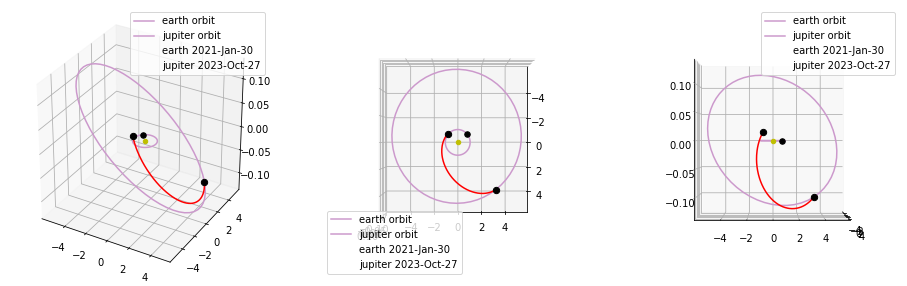

In [84]:
# Plot our trajectory
fig = plt.figure(figsize = (16,5))


ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')


ax1 = udp.plot(pop.champion_x, axes = ax1)

ax2 = udp.plot(pop.champion_x, axes = ax2)
ax2.view_init(elev=90, azim=0)

ax3 = udp.plot(pop.champion_x, axes = ax3)
ax3.view_init(elev=0, azim=0)

In [85]:
# Inspect
udp.pretty(pop.champion_x)

Total DV (m/s):  14997.127654690517
Dvs (m/s):  [723.7676394989445, 8485.214141564538, 5788.145873627033]
Tofs (days):  [101.55554159233222, 898.4444584076679]
